In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pylab import rcParams

from mlforecast import MLForecast

# from mlforecast.sklearn import SklearnForecast
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor

from src.data.loaders import CommodityLoader
from src.utils.split_series import split_series
from src.evaluation.evaluation import MetricEvaluator

In [3]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
dark_style = {
    'figure.facecolor': '#212946',
    'axes.facecolor': '#212946',
    'savefig.facecolor':'#212946',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': '#2A3459',
    'grid.linewidth': '1',
    'text.color': '0.9',
    'axes.labelcolor': '0.9',
    'xtick.color': '0.9',
    'ytick.color': '0.9',
    'font.size': 12 
}
plt.rcParams.update(dark_style)
rcParams['figure.figsize'] = (18,7)

In [4]:
df_brl = CommodityLoader.load_all_commodities(currency='BRL', preprocessing=True, monthly_aggregation='mean', limit_date=None)

ദ്ദി・ᴗ・)✧ acucar_santos carregado com sucesso
ദ്ദി・ᴗ・)✧ acucar_sp carregado com sucesso
ദ്ദി・ᴗ・)✧ algodao carregado com sucesso
ദ്ദി・ᴗ・)✧ arroz carregado com sucesso
ദ്ദി・ᴗ・)✧ cafe_arabica carregado com sucesso
ദ്ദി・ᴗ・)✧ cafe_robusta carregado com sucesso
ദ്ദി・ᴗ・)✧ milho carregado com sucesso
ദ്ദി・ᴗ・)✧ soja_parana carregado com sucesso
ദ്ദി・ᴗ・)✧ soja_paranagua carregado com sucesso
ദ്ദി・ᴗ・)✧ trigo_parana carregado com sucesso
ദ്ദി・ᴗ・)✧ trigo_rs carregado com sucesso


In [5]:
df_brl.head()

,ds,y,unique_id
0,2020-01-01,73.428636,ACUCAR_SANTOS
1,2020-02-01,81.636111,ACUCAR_SANTOS
2,2020-03-01,79.906364,ACUCAR_SANTOS
3,2020-04-01,77.113500,ACUCAR_SANTOS
4,2020-05-01,84.638500,ACUCAR_SANTOS


In [6]:
train, val, test = split_series(df_brl)

Treino + Val ACUCAR_SANTOS: 45 | Teste ACUCAR_SANTOS: 20
Treino + Val ACUCAR_SP: 185 | Teste ACUCAR_SP: 80
Treino + Val ALGODAO: 243 | Teste ALGODAO: 105
Treino + Val ARROZ: 168 | Teste ARROZ: 72
Treino + Val CAFE_ARABICA: 241 | Teste CAFE_ARABICA: 104
Treino + Val CAFE_ROBUSTA: 201 | Teste CAFE_ROBUSTA: 87
Treino + Val MILHO: 175 | Teste MILHO: 75
Treino + Val SOJA_PARANA: 234 | Teste SOJA_PARANA: 101
Treino + Val SOJA_PARANAGUA: 161 | Teste SOJA_PARANAGUA: 70
Treino + Val TRIGO_PARANA: 179 | Teste TRIGO_PARANA: 77
Treino + Val TRIGO_RS: 179 | Teste TRIGO_RS: 77
Splitted data into TRAIN with size 1605, VALIDATION with size 406 and TEST with size 868


In [7]:
model_lgbm = LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=10,
    num_leaves=63,
    min_child_samples=5,
    reg_alpha=0,
    reg_lambda=0.01,
    random_state=42,
    verbose=-1 # no printing
)

fcst = MLForecast(
    models={'lgbm': model_lgbm},
    lags=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    freq='MS'
)

In [8]:
# start tunning here if needed eventually

In [9]:
full_train = pd.concat([train, val])

In [10]:
fcst.fit(full_train)

MLForecast(models=[lgbm], freq=MS, lag_features=['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12'], date_features=[], num_threads=1)

In [11]:
# Rollout
forecasts = []
for i in range(len(test)):
    f_next = fcst.predict(h=1)
    forecasts.append(f_next)

    # add real value
    obs = test.iloc[[i]][['unique_id', 'ds', 'y']]
    fcst.update(obs)

In [12]:
forecasts_df = pd.concat(forecasts, ignore_index=True)

In [13]:
evaluator = MetricEvaluator()

In [14]:
results = evaluator.evaluate_multiple(
    forecasts_df=forecasts_df,    
    actual_df=test,                
    model_columns=['lgbm'],         
    groupby_column='unique_id'     
)

print(results)

         unique_id Model  n_observations        MAE      MAPE           MSE  \
0    ACUCAR_SANTOS  lgbm              20  10.888742  0.073501    185.271572   
1        ACUCAR_SP  lgbm             100   5.083091  0.049781     42.465542   
2          ALGODAO  lgbm             205  16.449954  0.049479    554.758092   
3            ARROZ  lgbm             277   4.105484  0.077361     26.263585   
4     CAFE_ARABICA  lgbm             381  60.560466  0.044722  51543.043967   
5     CAFE_ROBUSTA  lgbm             468  38.284903  0.067013  15720.790892   
6            MILHO  lgbm             543   2.316465  0.051449      7.957673   
7      SOJA_PARANA  lgbm             644   6.205098  0.080884     44.251304   
8   SOJA_PARANAGUA  lgbm             714   8.104150  0.091940     69.421341   
9     TRIGO_PARANA  lgbm             791  81.898139  0.070027  34698.829896   
10        TRIGO_RS  lgbm             868  55.090113  0.047379  23858.682713   

          RMSE        R2  
0    13.611450 -0.495523

In [15]:
summary = evaluator.get_summary_stats(results)
print("\n=== Estatísticas Resumo ===")
print(summary)


=== Estatísticas Resumo ===
           MAE                                      MAPE                  \
          mean      std     min      max   median   mean     std     min   
Model                                                                      
lgbm   26.2715  27.9729  2.3165  81.8981  10.8887  0.064  0.0161  0.0447   

                             MSE                                           \
          max median        mean         std     min        max    median   
Model                                                                       
lgbm   0.0919  0.067  11522.8851  17935.6625  7.9577  51543.044  185.2716   

          RMSE                                          R2                  \
          mean      std     min       max   median    mean     std     min   
Model                                                                        
lgbm   69.0694  86.1831  2.8209  227.0309  13.6115  0.5954  0.4871 -0.4955   

                       
          max  media

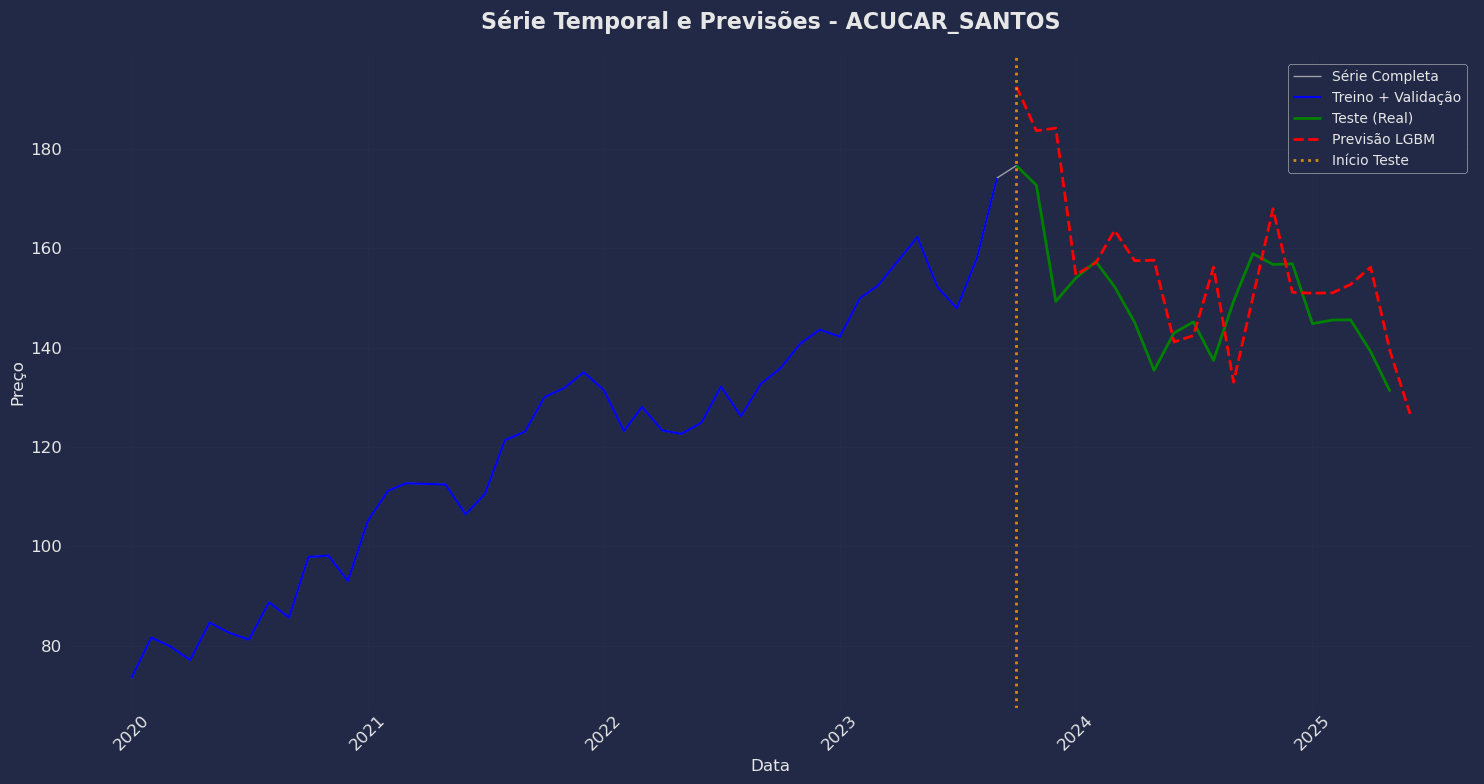

Gráfico exibido para: ACUCAR_SANTOS
--------------------------------------------------


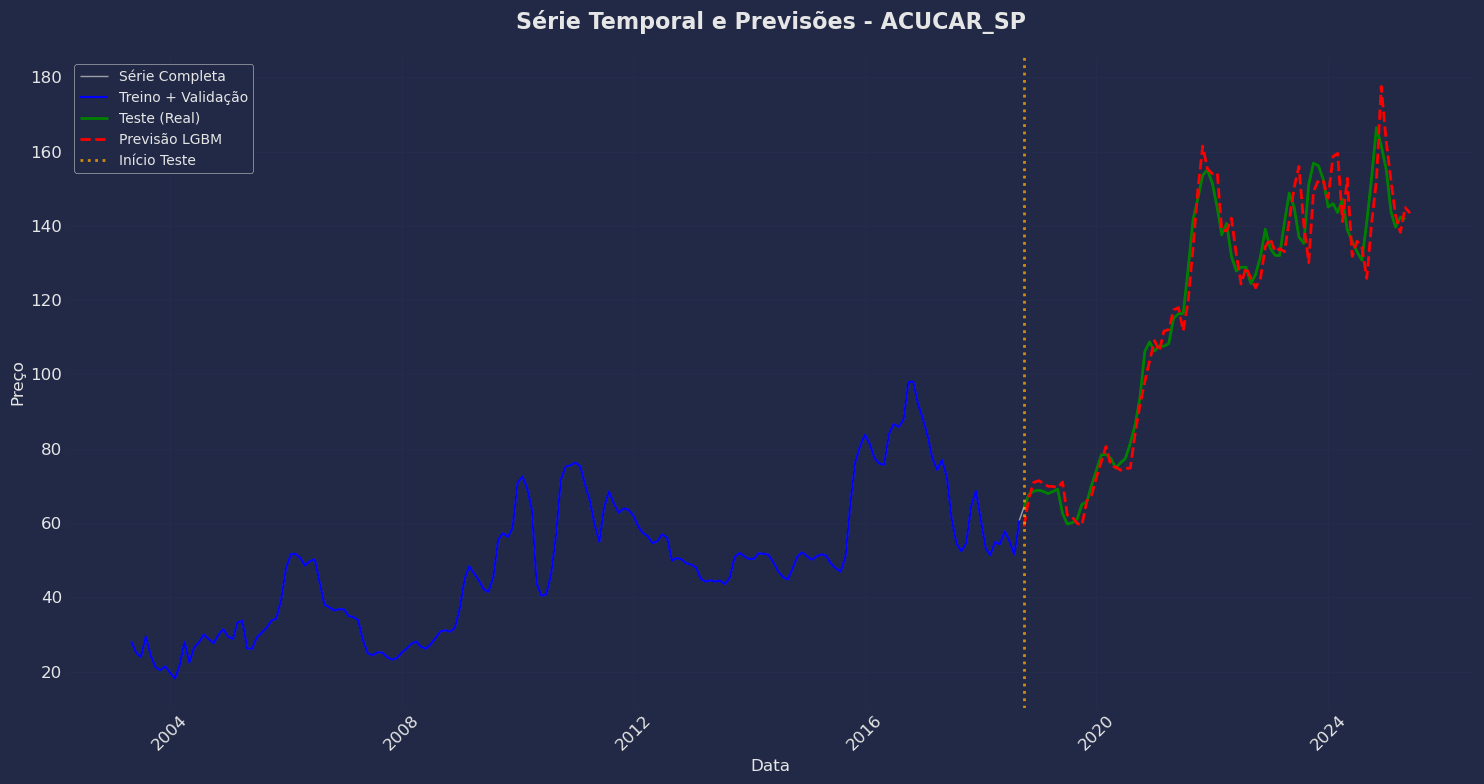

Gráfico exibido para: ACUCAR_SP
--------------------------------------------------


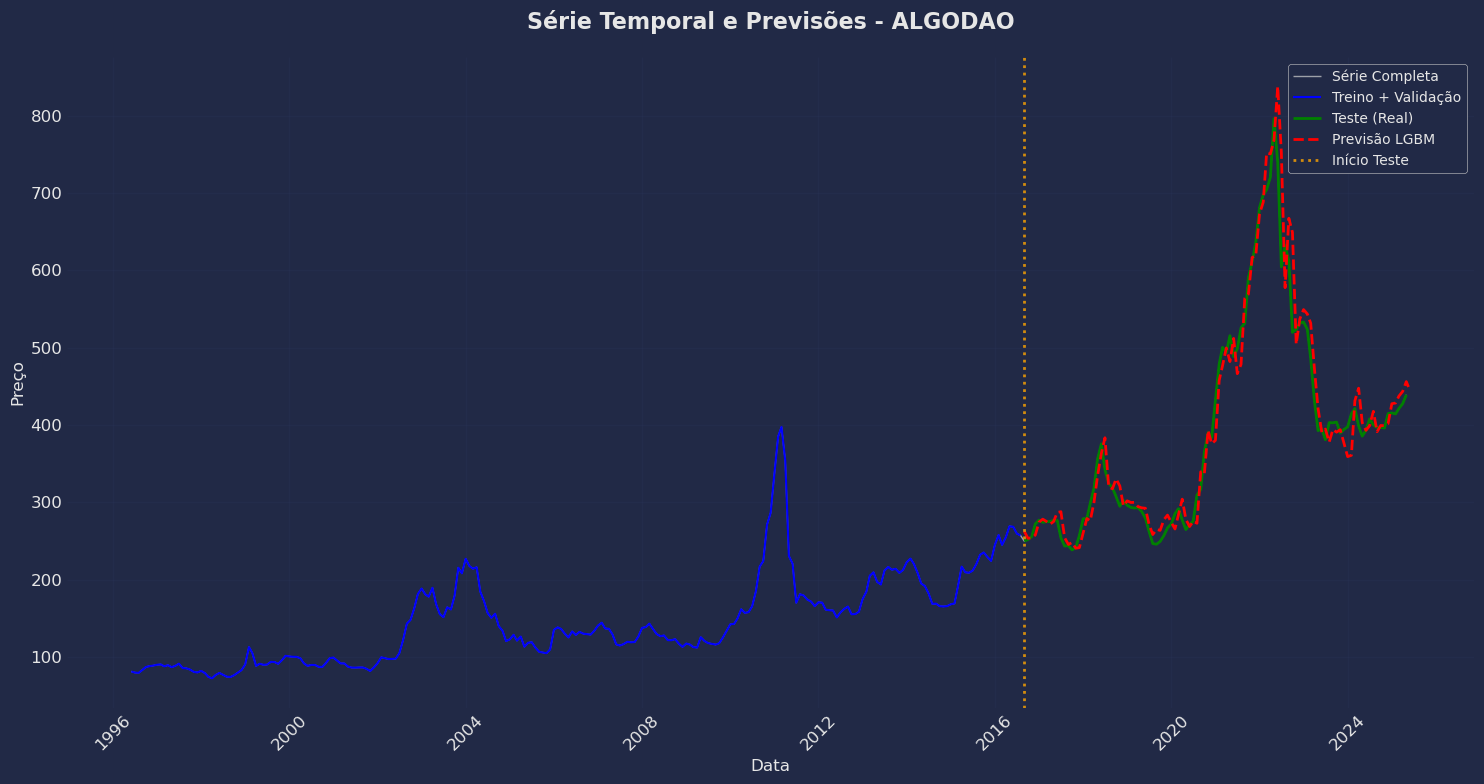

Gráfico exibido para: ALGODAO
--------------------------------------------------


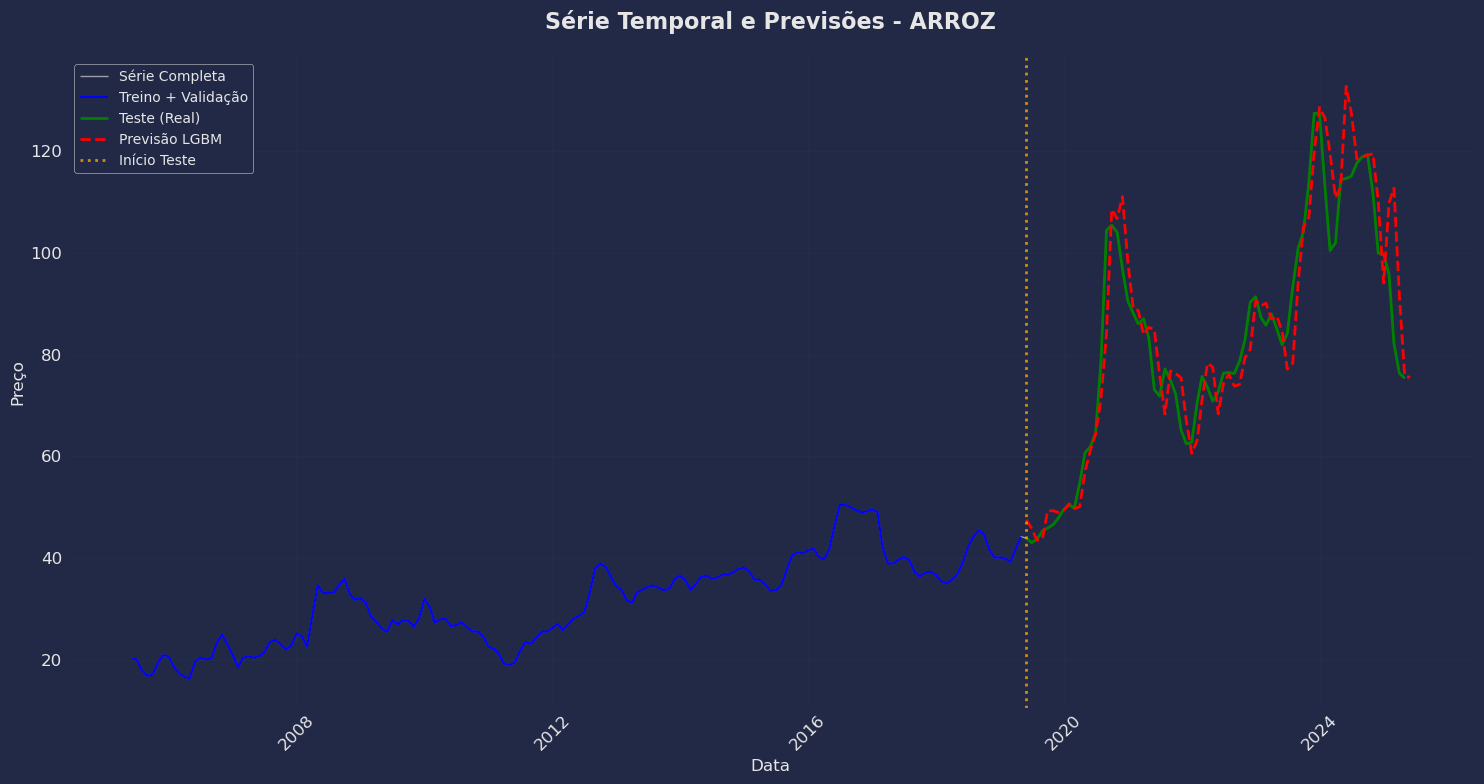

Gráfico exibido para: ARROZ
--------------------------------------------------


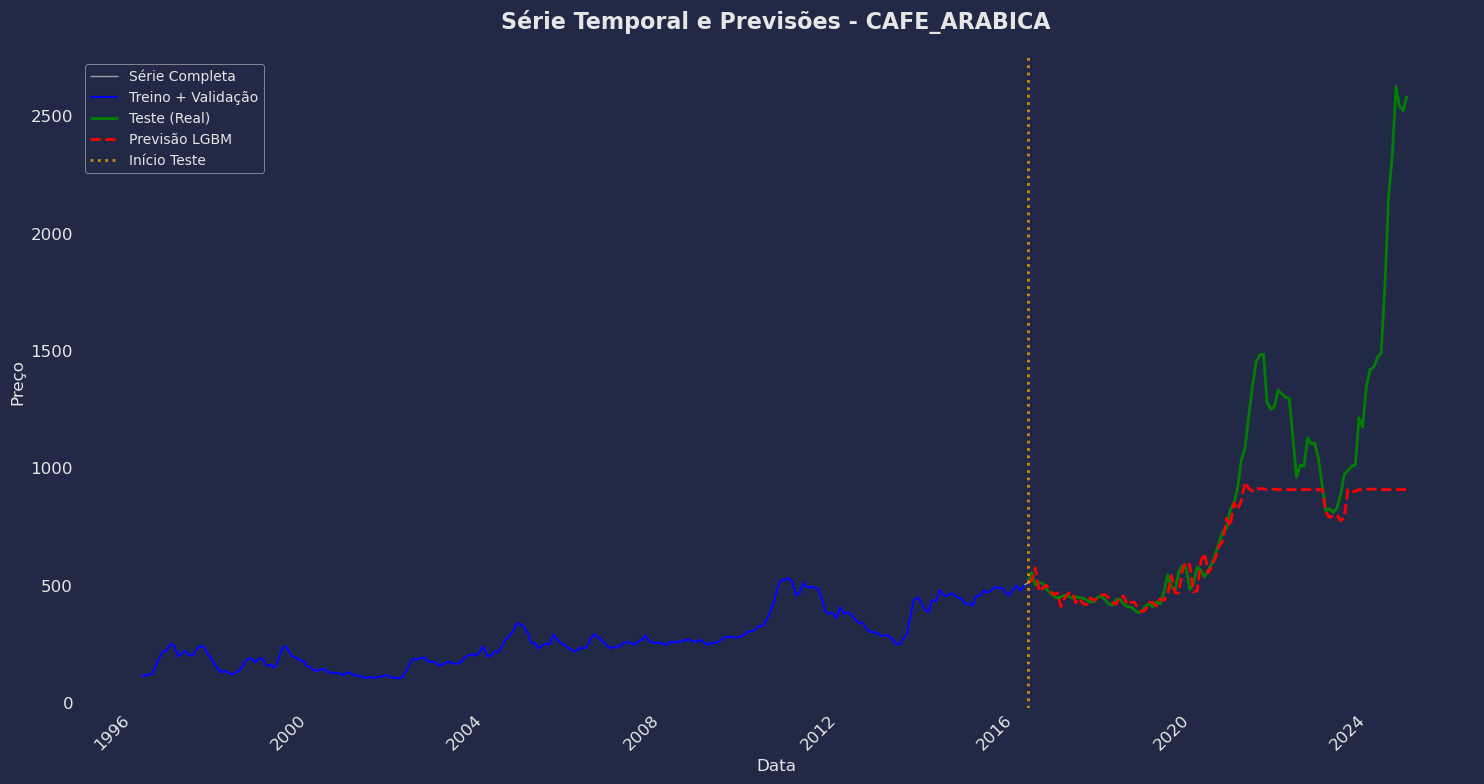

Gráfico exibido para: CAFE_ARABICA
--------------------------------------------------


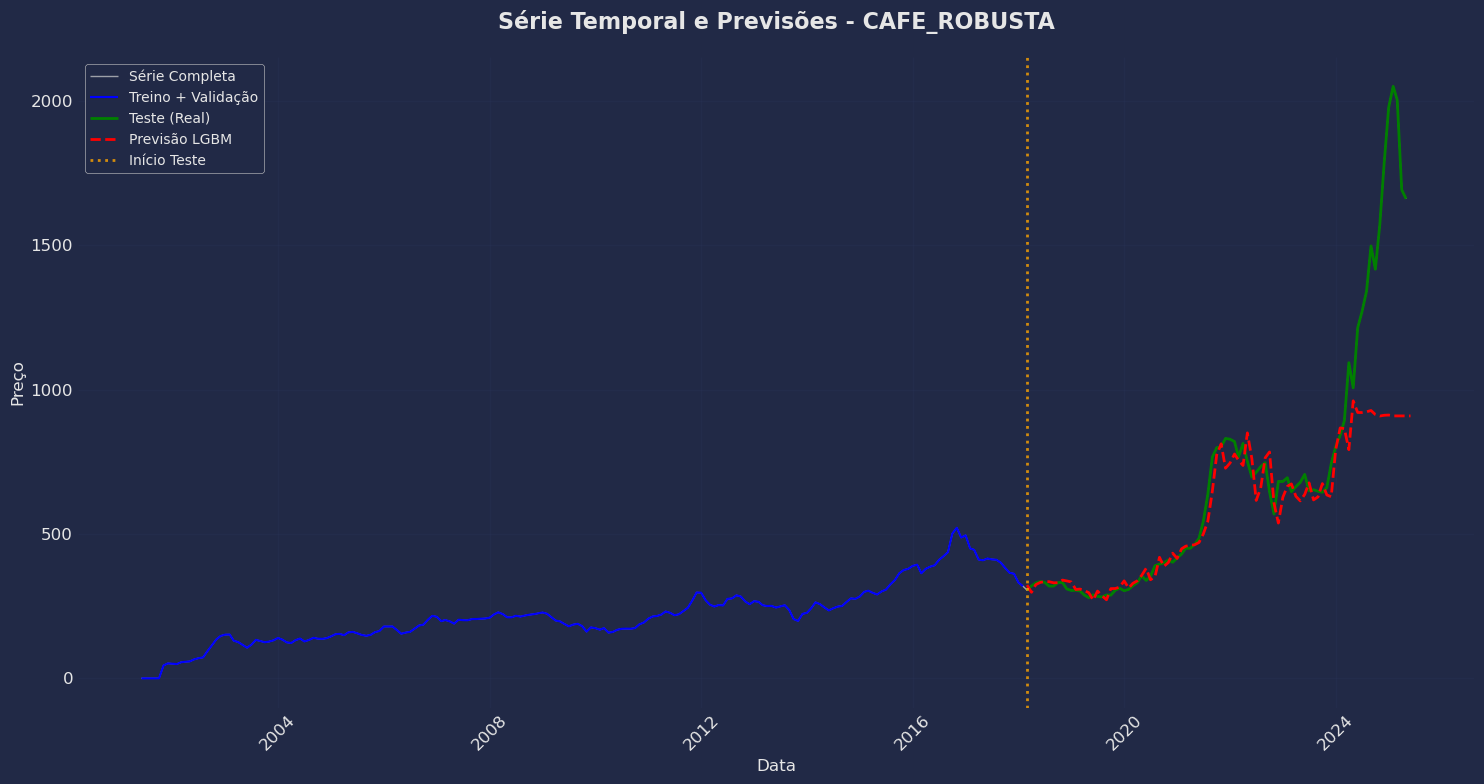

Gráfico exibido para: CAFE_ROBUSTA
--------------------------------------------------


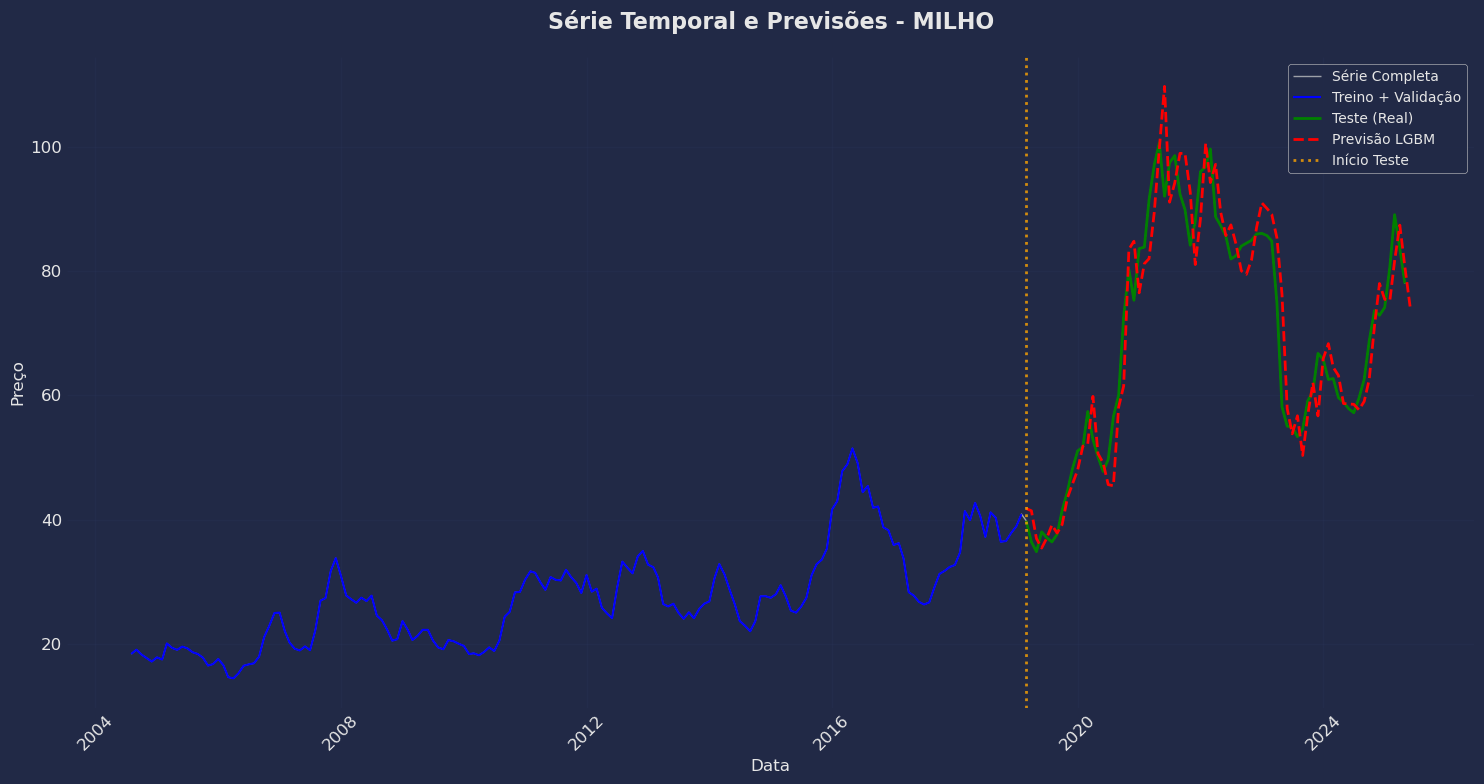

Gráfico exibido para: MILHO
--------------------------------------------------


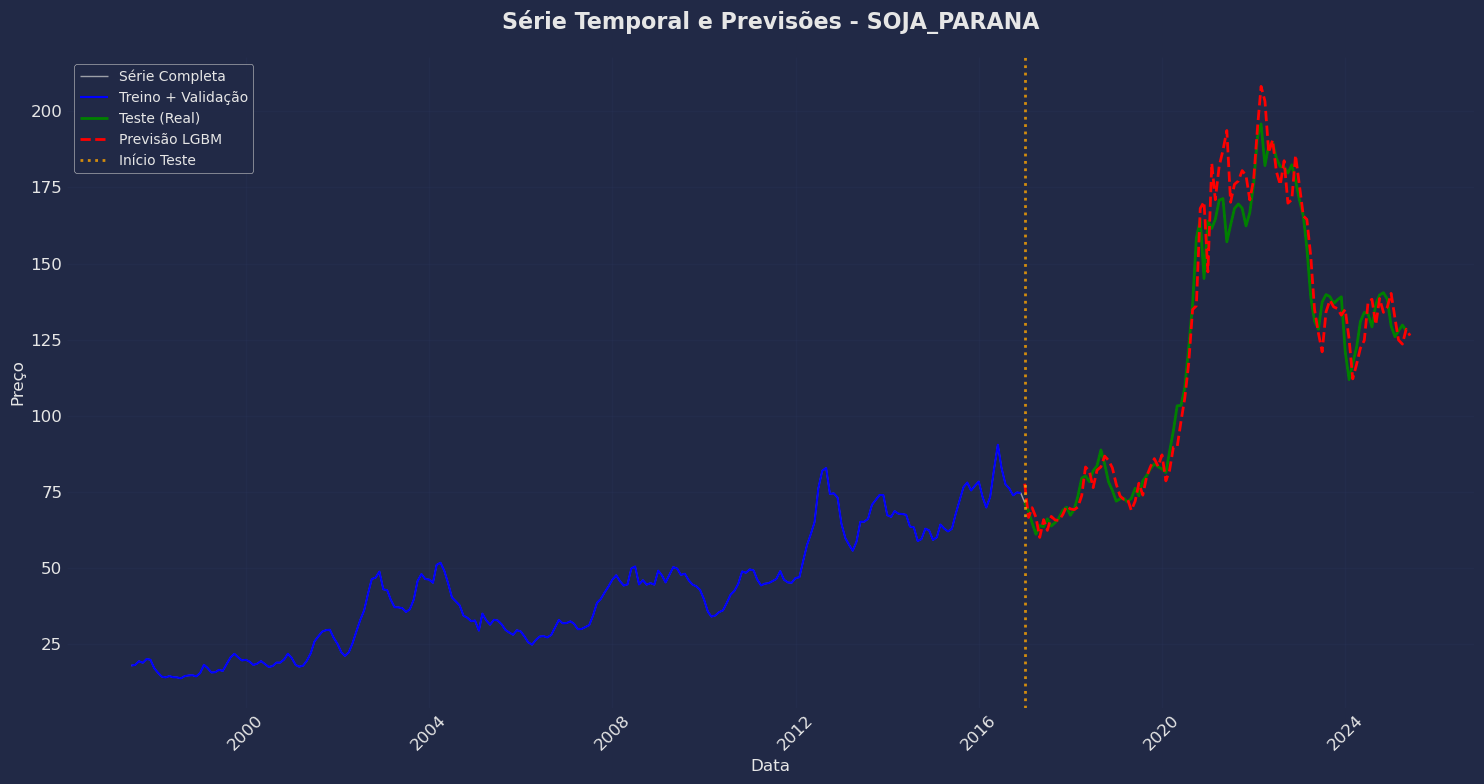

Gráfico exibido para: SOJA_PARANA
--------------------------------------------------


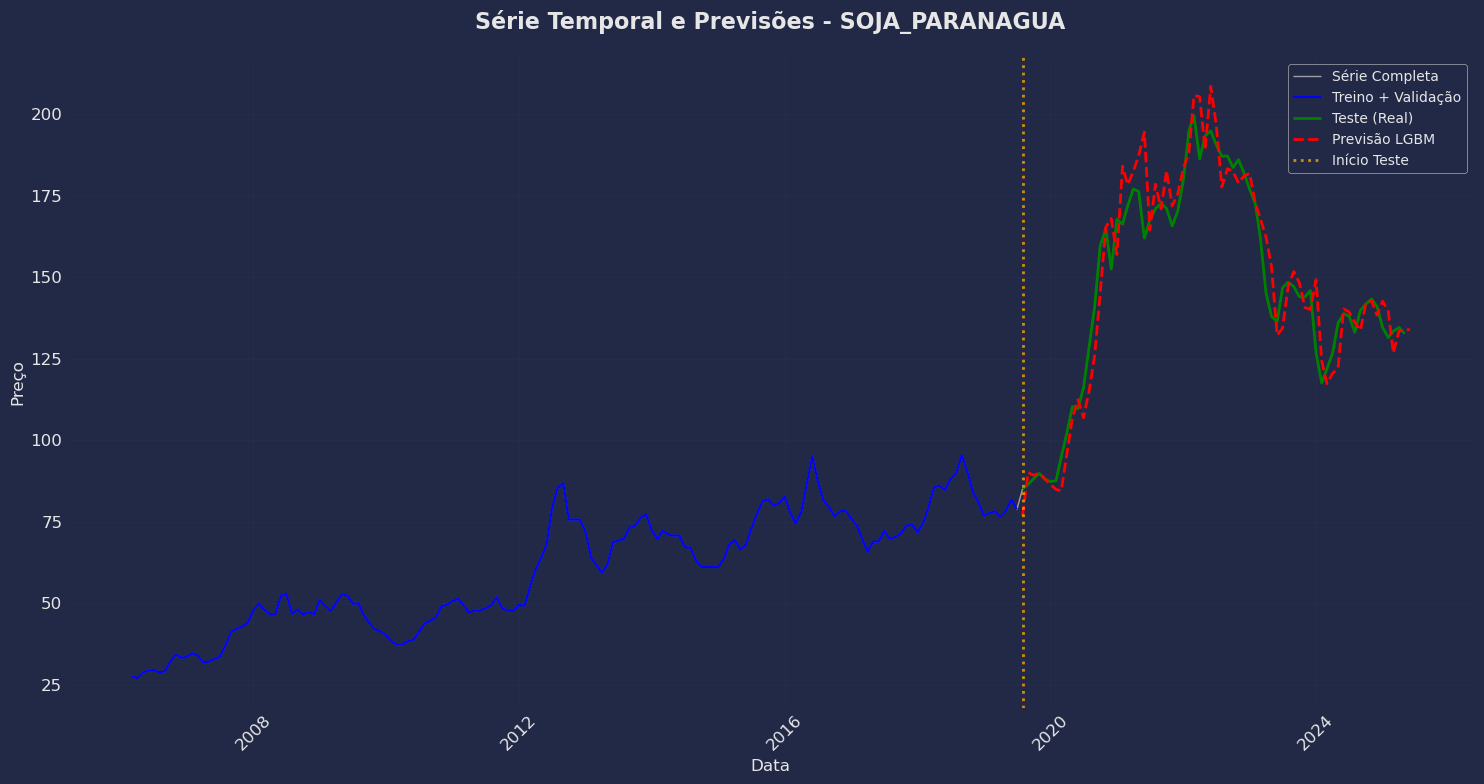

Gráfico exibido para: SOJA_PARANAGUA
--------------------------------------------------


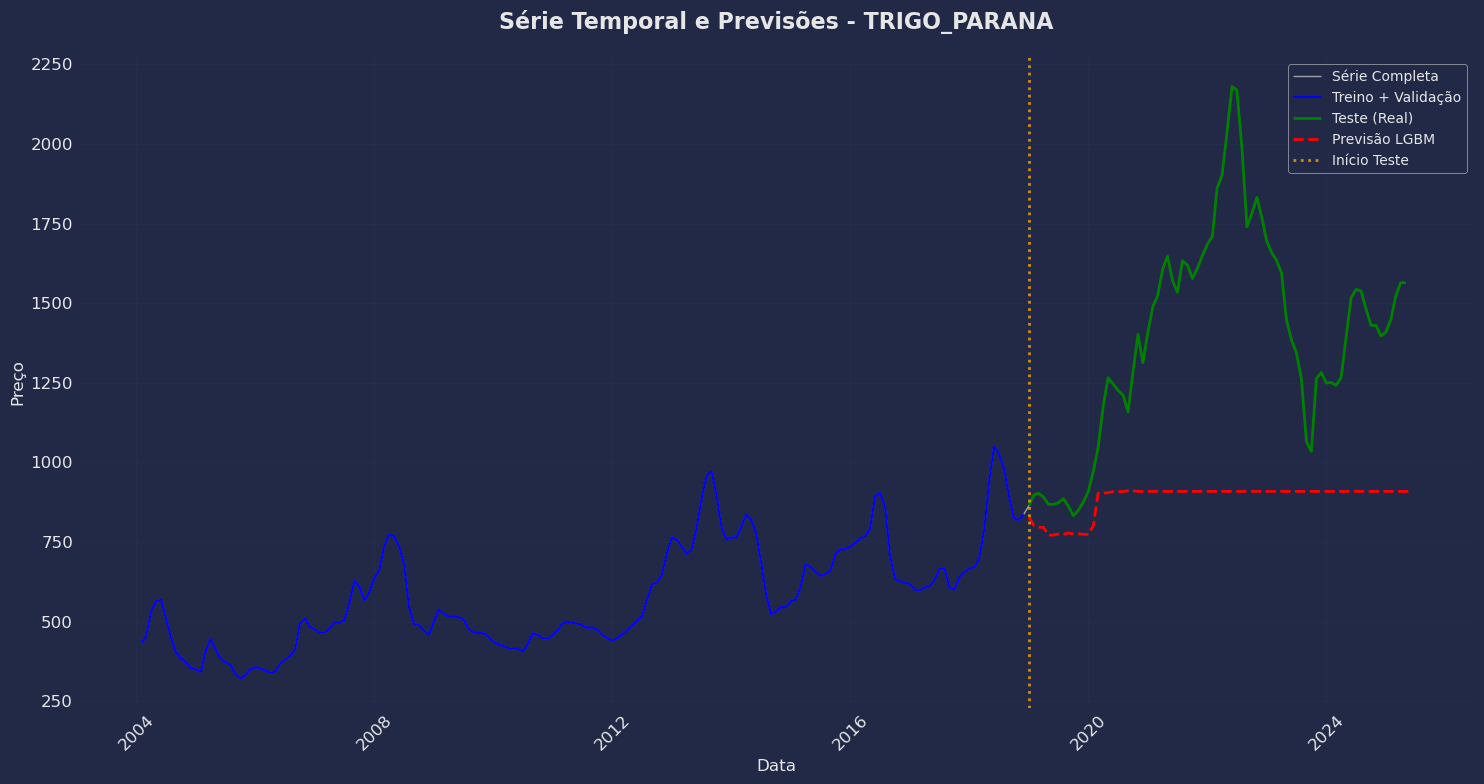

Gráfico exibido para: TRIGO_PARANA
--------------------------------------------------


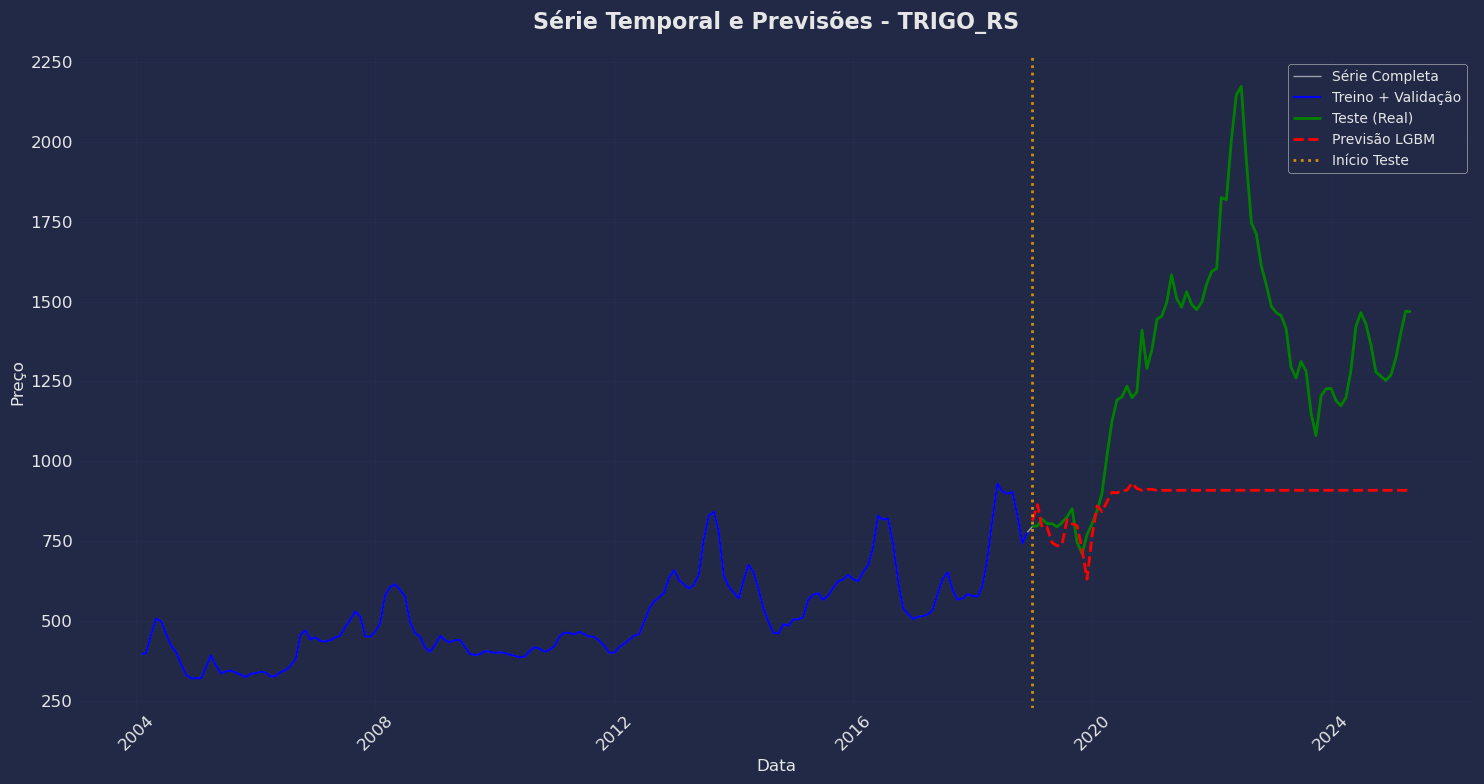

Gráfico exibido para: TRIGO_RS
--------------------------------------------------


In [16]:
def plot_series_and_forecasts(df_brl, full_train, test, forecasts_df):
    """
    Plota a série completa e as previsões para cada commodity individualmente
    """
    unique_ids = df_brl['unique_id'].unique()
    
    for uid in unique_ids:
        fig, ax = plt.subplots(1, 1, figsize=(15, 8))
        
        series_data = df_brl[df_brl['unique_id'] == uid].copy()
        train_data = full_train[full_train['unique_id'] == uid].copy()
        test_data = test[test['unique_id'] == uid].copy()
        forecast_data = forecasts_df[forecasts_df['unique_id'] == uid].copy()
        
        ax.plot(series_data['ds'], series_data['y'], 
                color='lightgray', alpha=0.7, linewidth=1, label='Série Completa')
        
        ax.plot(train_data['ds'], train_data['y'], 
                color='blue', linewidth=1.5, label='Treino + Validação')
        
        ax.plot(test_data['ds'], test_data['y'], 
                color='green', linewidth=2, label='Teste (Real)')
        
        ax.plot(forecast_data['ds'], forecast_data['lgbm'], 
                color='red', linewidth=2, linestyle='--', label='Previsão LGBM')
        
        if len(test_data) > 0:
            ax.axvline(x=test_data['ds'].iloc[0], color='orange', 
                      linestyle=':', alpha=0.8, linewidth=2, label='Início Teste')
        
        ax.set_title(f'Série Temporal e Previsões - {uid}', 
                    fontsize=16, fontweight='bold', pad=20)
        ax.set_xlabel('Data', fontsize=12)
        ax.set_ylabel('Preço', fontsize=12)
        ax.legend(fontsize=10, loc='best')
        ax.grid(True, alpha=0.3)
        
        ax.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        
        plt.show()
        
        print(f"Gráfico exibido para: {uid}")
        print("-" * 50)

plot_series_and_forecasts(df_brl, full_train, test, forecasts_df)

In [17]:
model = GradientBoostingRegressor(
    n_estimators=1000, 
    max_depth=10,
    learning_rate=0.1, min_samples_leaf=5
)

fcst = MLForecast(
    models={'gbm': model},
    lags=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    freq='MS'
)

In [18]:
# start tunning here if needed eventually

In [19]:
full_train = pd.concat([train, val])

In [20]:
fcst.fit(full_train)

MLForecast(models=[gbm], freq=MS, lag_features=['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12'], date_features=[], num_threads=1)

In [21]:
# Rollout
forecasts = []
for i in range(len(test)):
    f_next = fcst.predict(h=1)
    forecasts.append(f_next)

    # add real value
    obs = test.iloc[[i]][['unique_id', 'ds', 'y']]
    fcst.update(obs)

In [22]:
forecasts_df = pd.concat(forecasts, ignore_index=True)

In [23]:
evaluator = MetricEvaluator()

In [24]:
results = evaluator.evaluate_multiple(
    forecasts_df=forecasts_df,    
    actual_df=test,                
    model_columns=['gbm'],         
    groupby_column='unique_id'     
)

print(results)

         unique_id Model  n_observations         MAE      MAPE           MSE  \
0    ACUCAR_SANTOS   gbm              20   10.244844  0.069116    157.276506   
1        ACUCAR_SP   gbm             100    4.291931  0.037087     38.483104   
2          ALGODAO   gbm             205   16.125501  0.046542    630.008400   
3            ARROZ   gbm             277    2.912377  0.049846     16.899271   
4     CAFE_ARABICA   gbm             381   69.185046  0.058999  53930.224980   
5     CAFE_ROBUSTA   gbm             468   39.857770  0.070803  16587.123104   
6            MILHO   gbm             543    3.646172  0.085312     14.957276   
7      SOJA_PARANA   gbm             644    5.110438  0.065938     31.985426   
8   SOJA_PARANAGUA   gbm             714    7.822636  0.088148     64.887180   
9     TRIGO_PARANA   gbm             791  107.324390  0.098672  39055.572848   
10        TRIGO_RS   gbm             868   47.620020  0.037165  25189.296964   

          RMSE        R2  
0    12.5409

In [25]:
summary = evaluator.get_summary_stats(results)
print("\n=== Estatísticas Resumo ===")
print(summary)


=== Estatísticas Resumo ===
           MAE                                        MAPE                  \
          mean      std     min       max   median    mean     std     min   
Model                                                                        
gbm    28.5583  34.1798  2.9124  107.3244  10.2448  0.0643  0.0207  0.0371   

                              MSE                                            \
          max  median        mean         std      min        max    median   
Model                                                                         
gbm    0.0987  0.0659  12337.8832  19155.7098  14.9573  53930.225  157.2765   

          RMSE                                         R2                  \
          mean      std     min       max  median    mean     std     min   
Model                                                                       
gbm    71.1718  89.4411  3.8675  232.2288  12.541  0.5978  0.4614 -0.2695   

                      
         

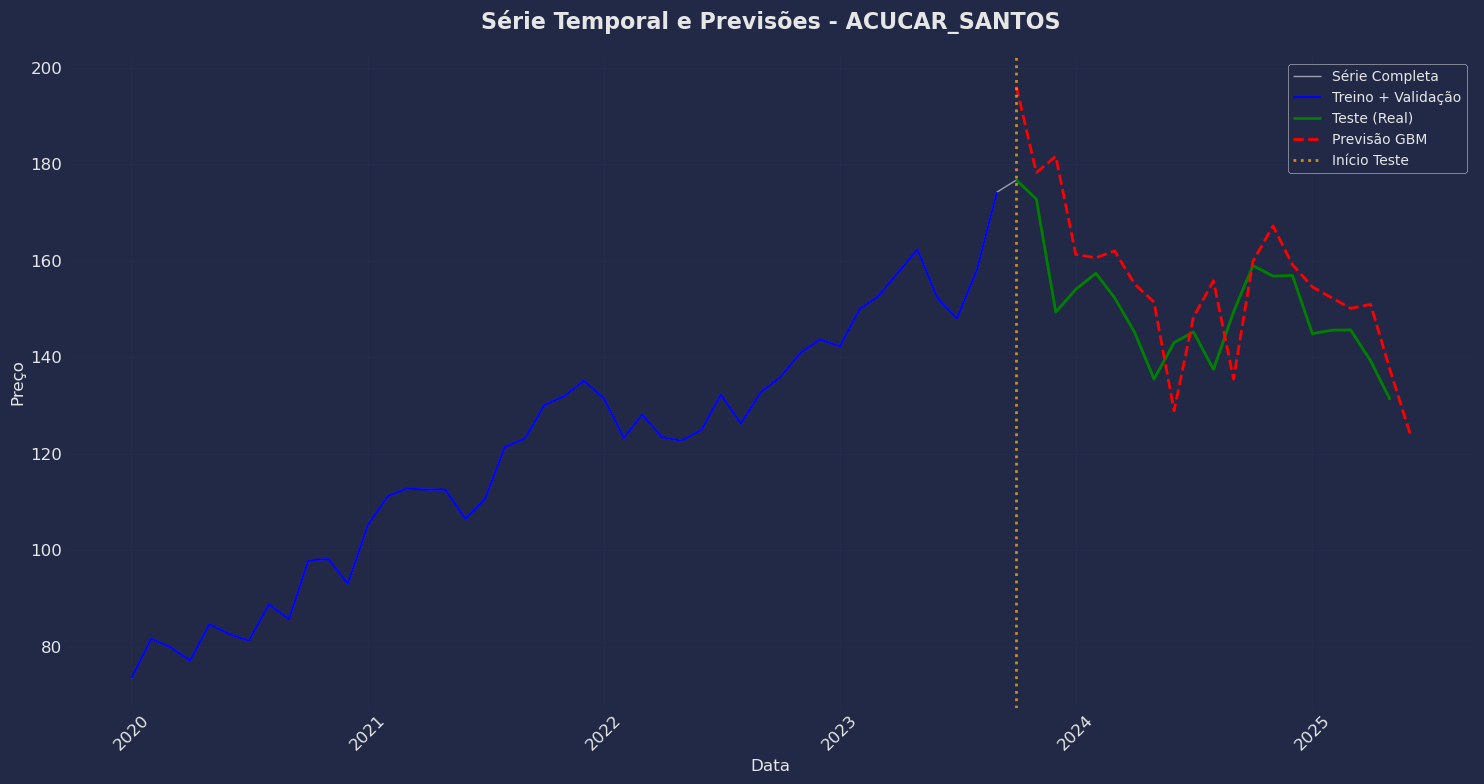

Gráfico exibido para: ACUCAR_SANTOS
--------------------------------------------------


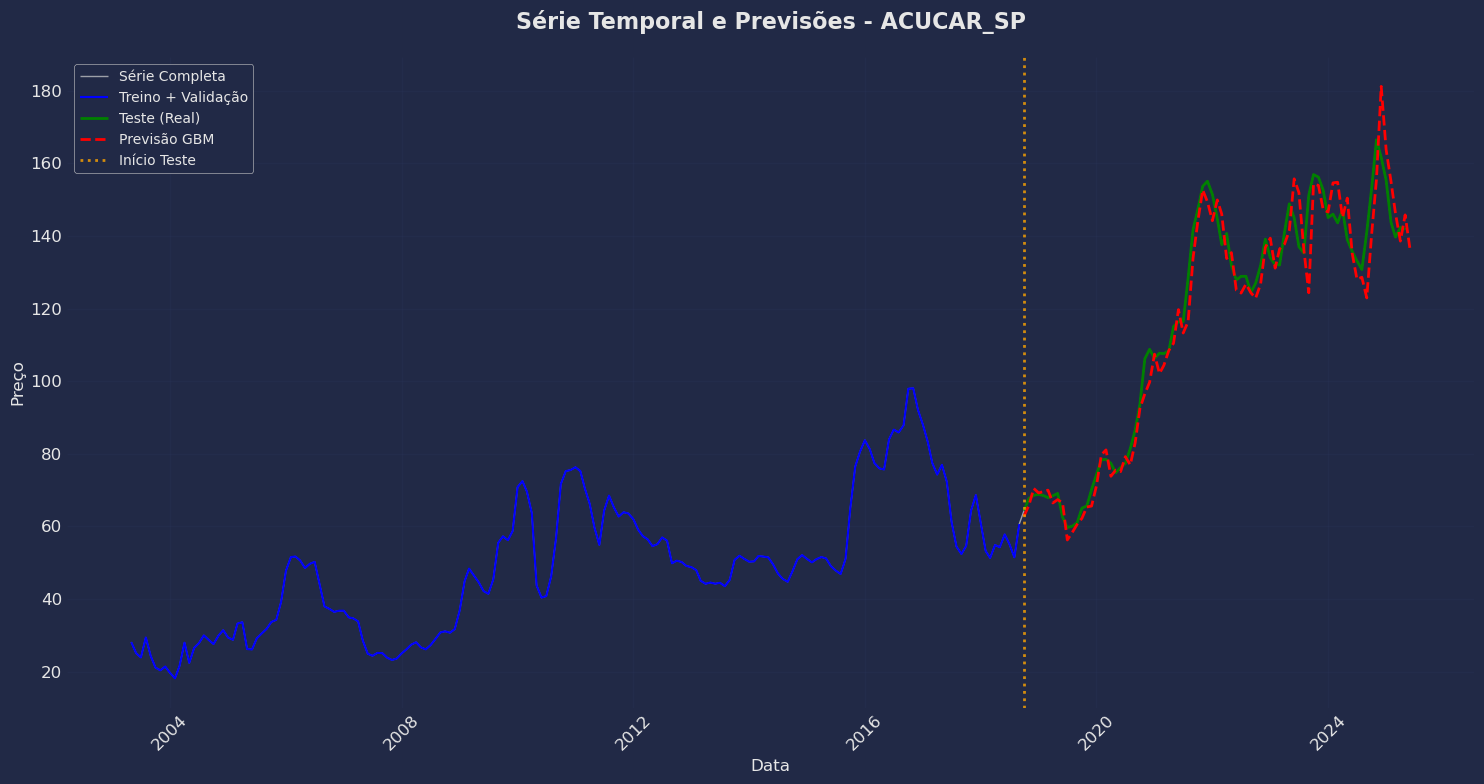

Gráfico exibido para: ACUCAR_SP
--------------------------------------------------


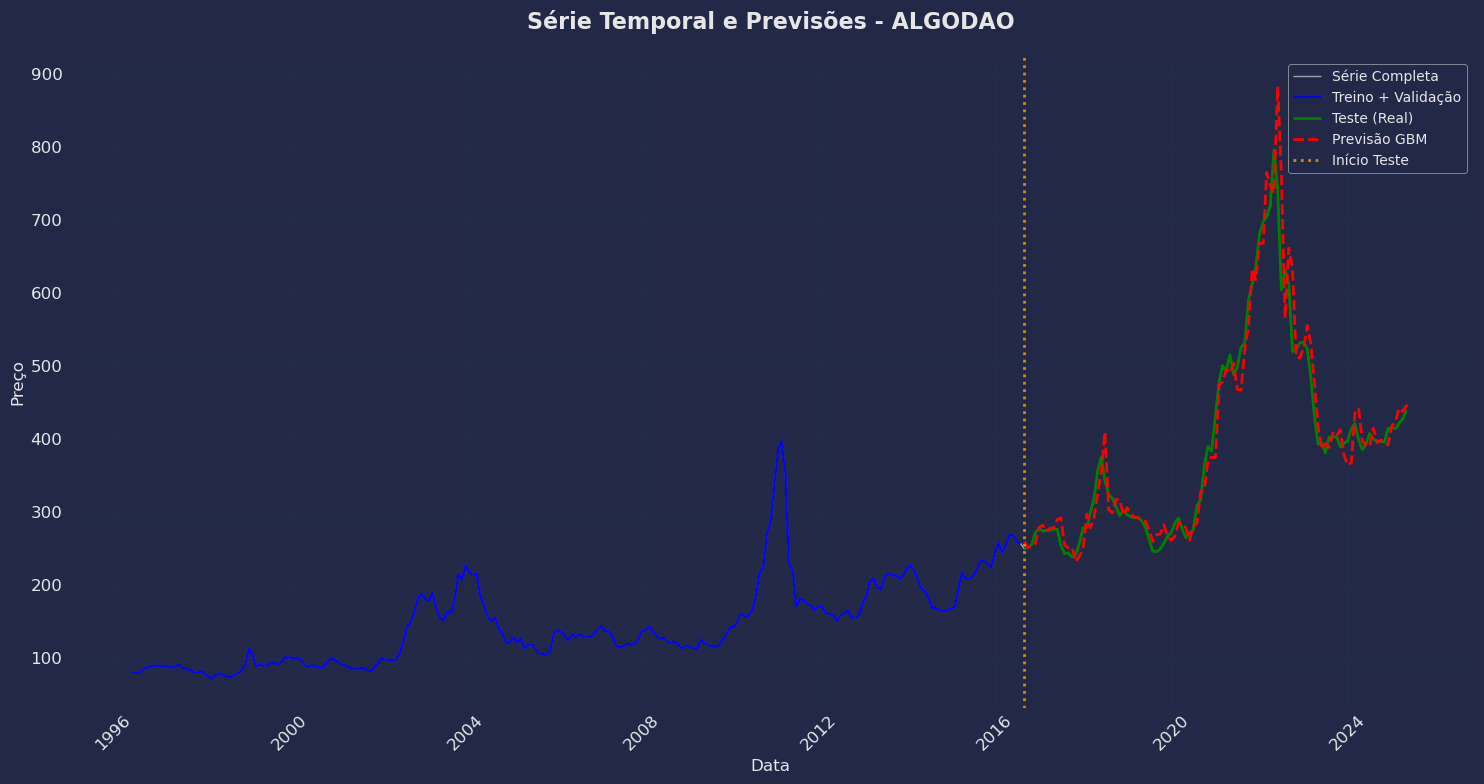

Gráfico exibido para: ALGODAO
--------------------------------------------------


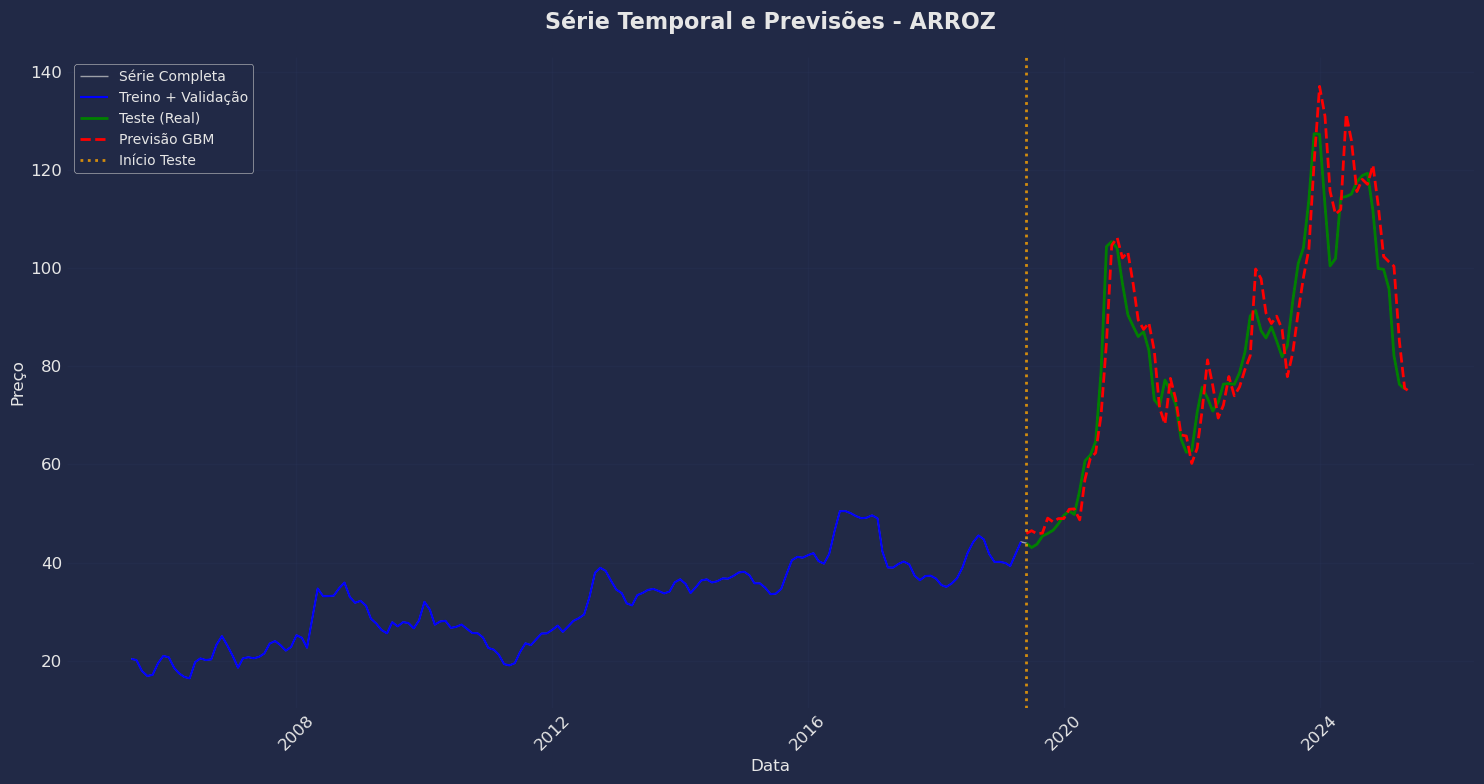

Gráfico exibido para: ARROZ
--------------------------------------------------


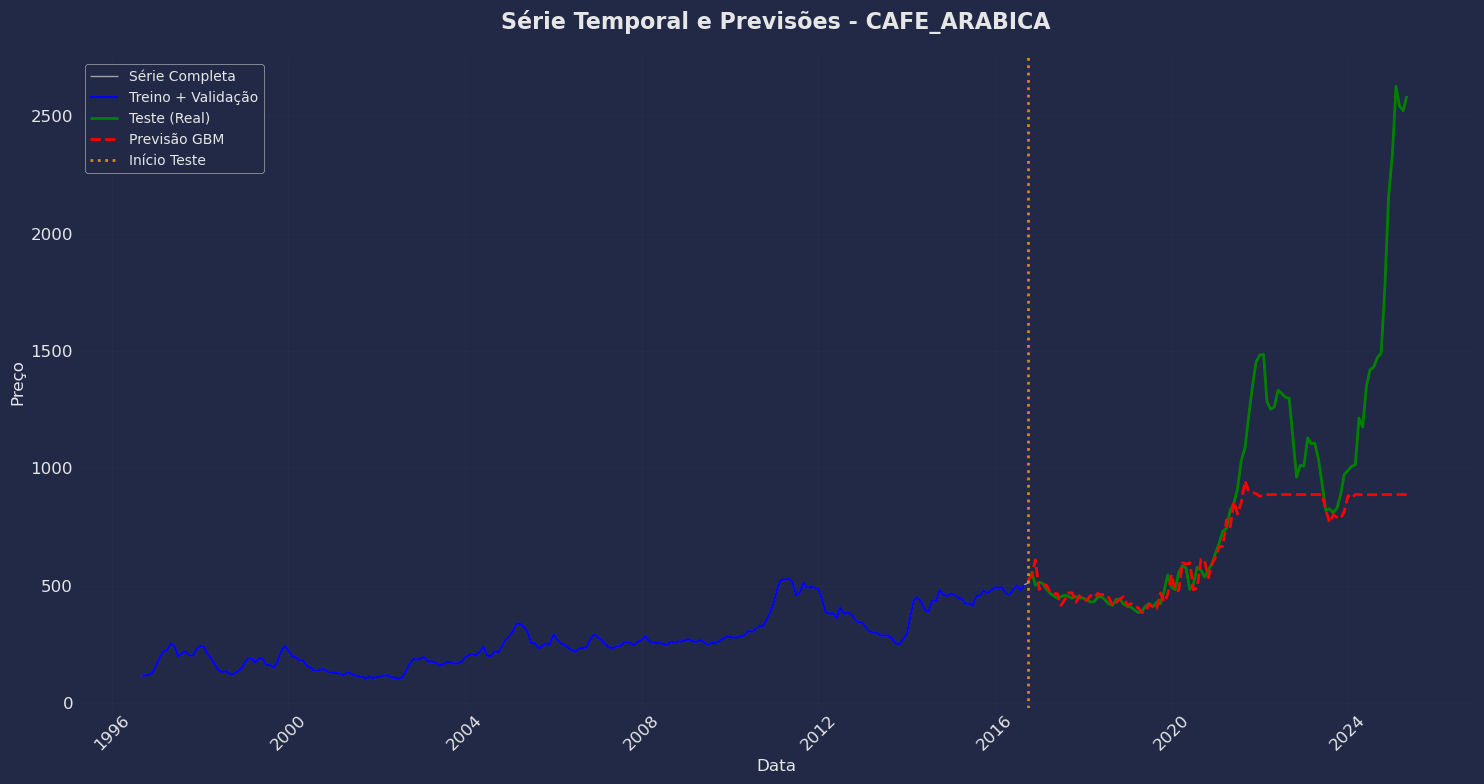

Gráfico exibido para: CAFE_ARABICA
--------------------------------------------------


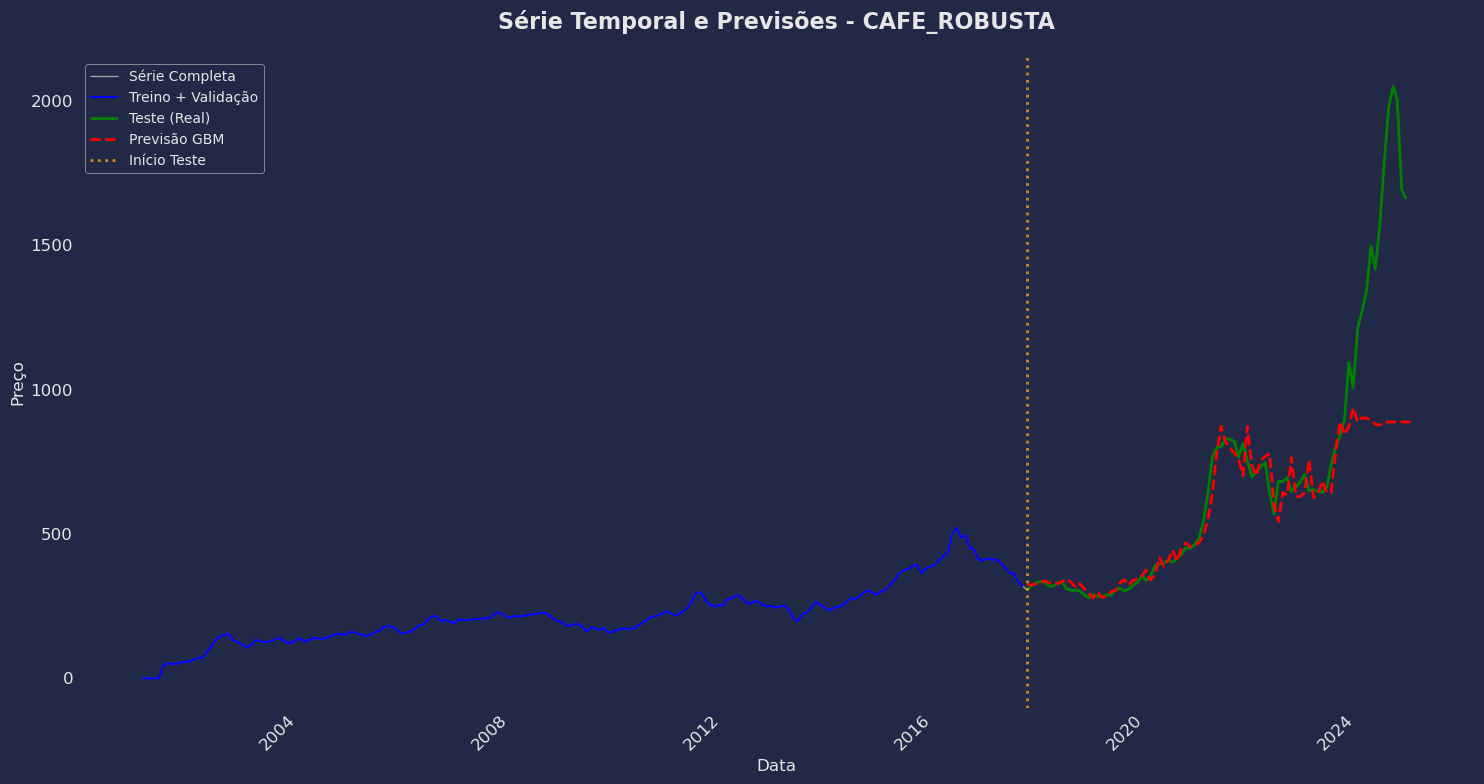

Gráfico exibido para: CAFE_ROBUSTA
--------------------------------------------------


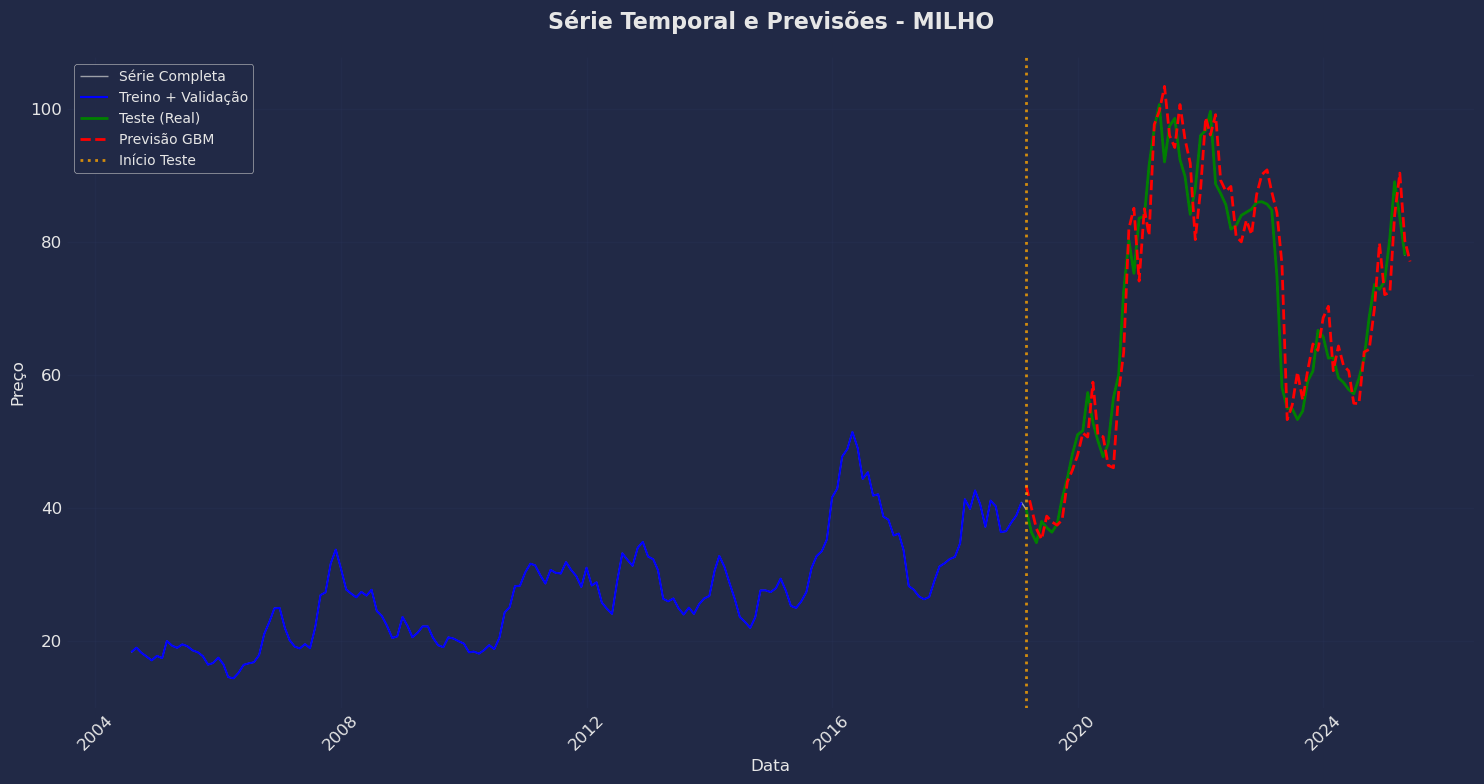

Gráfico exibido para: MILHO
--------------------------------------------------


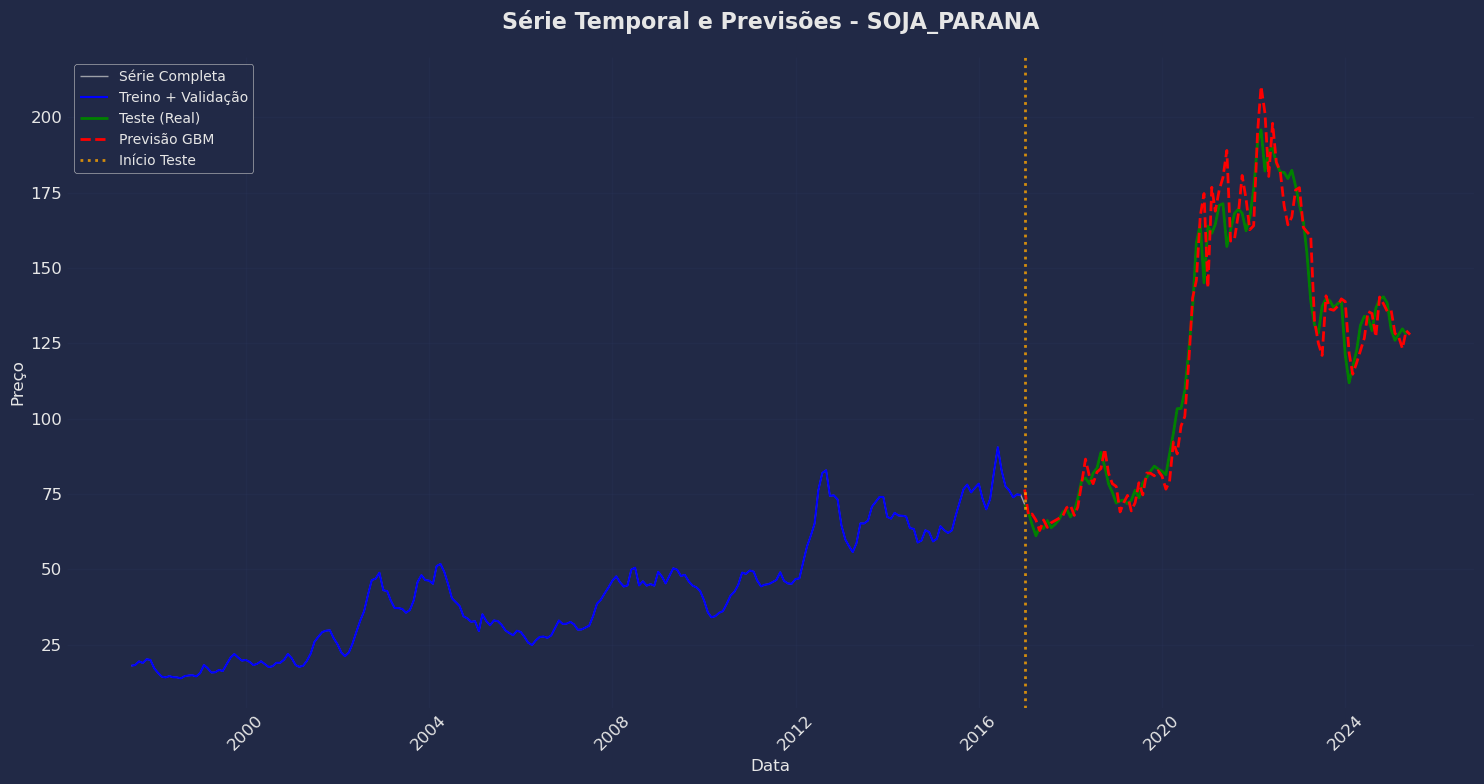

Gráfico exibido para: SOJA_PARANA
--------------------------------------------------


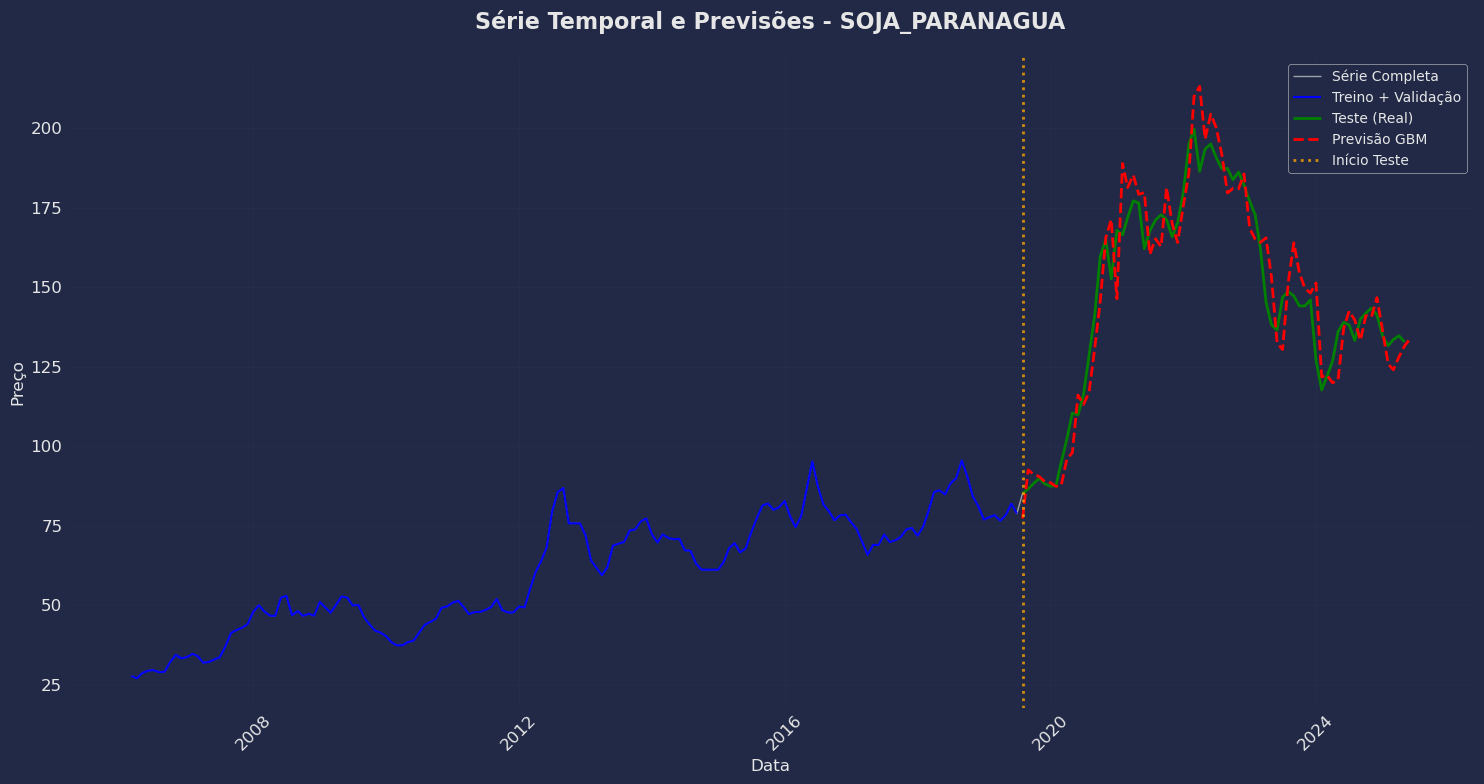

Gráfico exibido para: SOJA_PARANAGUA
--------------------------------------------------


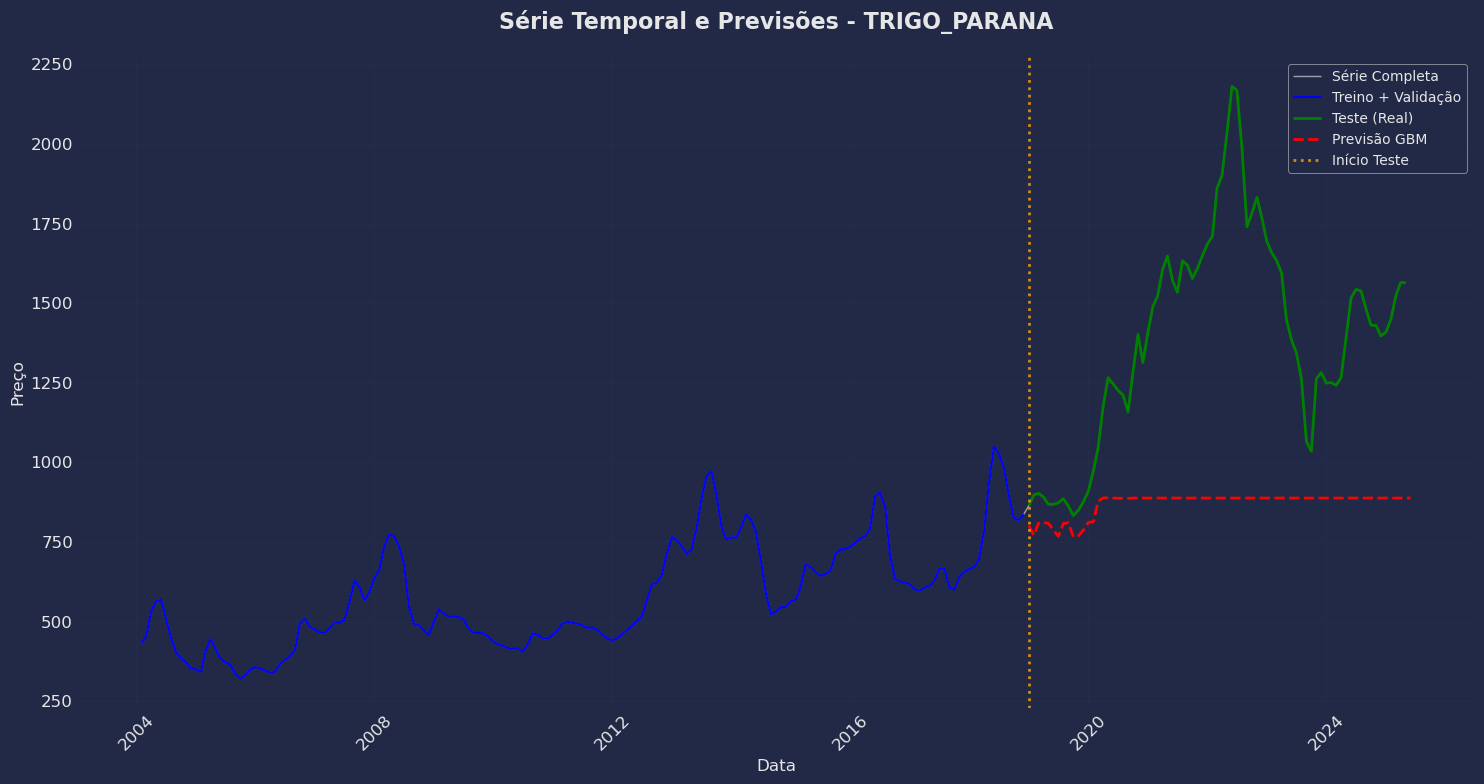

Gráfico exibido para: TRIGO_PARANA
--------------------------------------------------


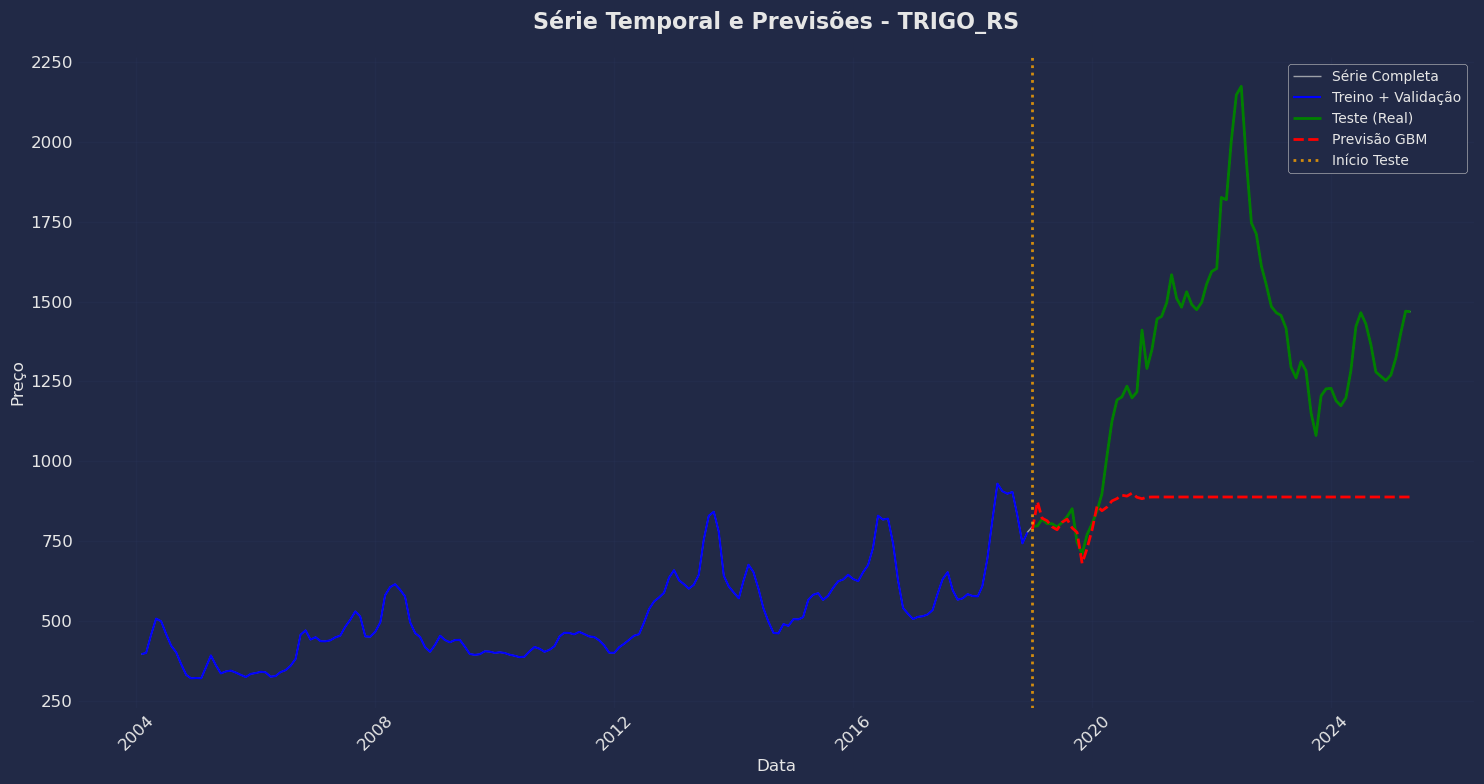

Gráfico exibido para: TRIGO_RS
--------------------------------------------------


In [26]:
def plot_series_and_forecasts(df_brl, full_train, test, forecasts_df):
    """
    Plota a série completa e as previsões para cada commodity individualmente
    """
    unique_ids = df_brl['unique_id'].unique()
    
    for uid in unique_ids:
        fig, ax = plt.subplots(1, 1, figsize=(15, 8))
        
        series_data = df_brl[df_brl['unique_id'] == uid].copy()
        train_data = full_train[full_train['unique_id'] == uid].copy()
        test_data = test[test['unique_id'] == uid].copy()
        forecast_data = forecasts_df[forecasts_df['unique_id'] == uid].copy()
        
        ax.plot(series_data['ds'], series_data['y'], 
                color='lightgray', alpha=0.7, linewidth=1, label='Série Completa')
        
        ax.plot(train_data['ds'], train_data['y'], 
                color='blue', linewidth=1.5, label='Treino + Validação')
        
        ax.plot(test_data['ds'], test_data['y'], 
                color='green', linewidth=2, label='Teste (Real)')
        
        ax.plot(forecast_data['ds'], forecast_data['gbm'], 
                color='red', linewidth=2, linestyle='--', label='Previsão GBM')
        
        if len(test_data) > 0:
            ax.axvline(x=test_data['ds'].iloc[0], color='orange', 
                      linestyle=':', alpha=0.8, linewidth=2, label='Início Teste')
        
        ax.set_title(f'Série Temporal e Previsões - {uid}', 
                    fontsize=16, fontweight='bold', pad=20)
        ax.set_xlabel('Data', fontsize=12)
        ax.set_ylabel('Preço', fontsize=12)
        ax.legend(fontsize=10, loc='best')
        ax.grid(True, alpha=0.3)
        
        ax.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        
        plt.show()
        
        print(f"Gráfico exibido para: {uid}")
        print("-" * 50)

plot_series_and_forecasts(df_brl, full_train, test, forecasts_df)